In [1]:
# Імпортуємо потрібні бібліотеки
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, normalized_mutual_info_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import seaborn as sns
from tqdm.notebook import tqdm
from torchvision.transforms import ToTensor, ToPILImage

In [2]:
# Перевіряємо доступність GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Визначаємо трансформації для ResNet18
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

Using device: cuda:0


In [3]:
# Завантаження датасету CIFAR10
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=128, shuffle=False, num_workers=2)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

In [4]:
# Завантаження ResNet18 та створення feature extractor
model = models.resnet18(pretrained=True)
feature_extractor = nn.Sequential(*list(model.children())[:-1]) #дістаньте перевід останній шар (до класифікаційного)
feature_extractor = feature_extractor.to(device)
feature_extractor.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [5]:
# Функція для витягу ознак із моделі
def extract_features(dataloader):
    features, labels = [], []
    with torch.no_grad():
        for images, targets in tqdm(dataloader):
            images = images.to(device)
            output = feature_extractor(images)
            output = output.view(-1, 512)
            features.append(output.cpu().numpy())
            labels.append(targets.numpy())
    features = np.vstack(features)
    labels = np.concatenate(labels)
    return features, labels

In [6]:
print("Extracting features...")
train_features, train_labels = extract_features(trainloader)
test_features, test_labels = extract_features(testloader)

Extracting features...


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

In [7]:
print("Normalizing features...")
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

Normalizing features...


In [8]:
print("Clustering with KMeans...")
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans.fit(train_features)

train_cluster_assignments = kmeans.predict(train_features)
test_cluster_assignments = kmeans.predict(test_features)

Clustering with KMeans...


In [9]:
# Функція оцінки кластеризації
def evaluate_clustering(true_labels, cluster_assignments, n_clusters):
    contingency_matrix = confusion_matrix(true_labels, cluster_assignments)
    cluster_to_class = {cluster: np.argmax(contingency_matrix[:, cluster]) for cluster in range(n_clusters)}
    remapped_clusters = np.array([cluster_to_class[cluster] for cluster in cluster_assignments])
    accuracy = accuracy_score(true_labels, remapped_clusters)
    nmi = normalized_mutual_info_score(true_labels, cluster_assignments)
    return accuracy, nmi, remapped_clusters, cluster_to_class

In [10]:
train_accuracy, train_nmi, train_remapped, cluster_mapping = evaluate_clustering(
    train_labels, train_cluster_assignments, n_clusters)
test_accuracy, test_nmi, test_remapped, _ = evaluate_clustering(
    test_labels, test_cluster_assignments, n_clusters)

print(f"Train Accuracy: {train_accuracy:.4f}, NMI: {train_nmi:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}, NMI: {test_nmi:.4f}")

Train Accuracy: 0.6807, NMI: 0.5643
Test Accuracy: 0.6786, NMI: 0.5591


Running t-SNE on 10000 samples...


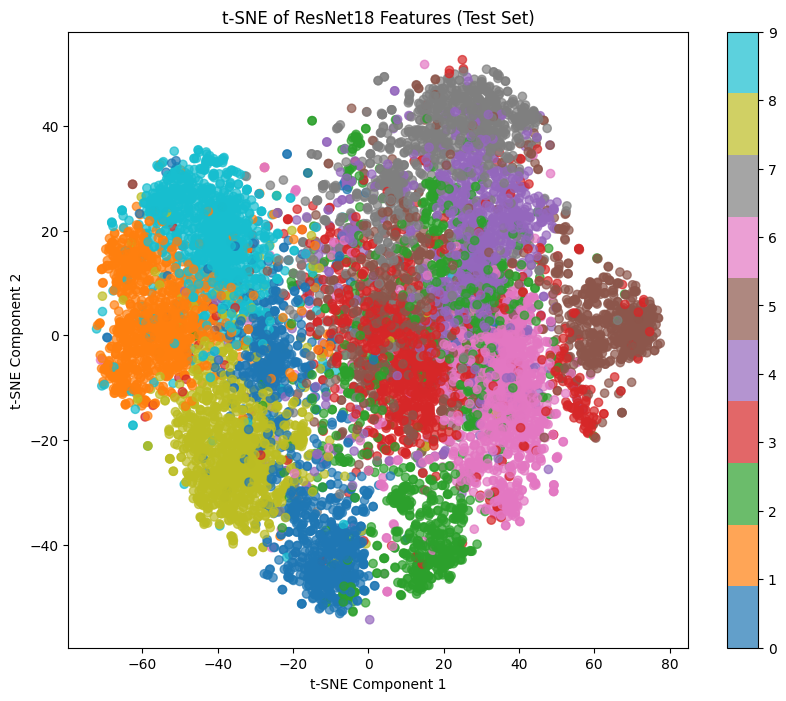

In [11]:
# Візуалізація через t-SNE
def visualize_embeddings(features, labels, title="t-SNE Embeddings"):
    print(f"Running t-SNE on {features.shape[0]} samples...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    embeddings_2d = tsne.fit_transform(features)
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter, ticks=range(10))
    plt.title(title)
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.show()

visualize_embeddings(test_features, test_labels, title="t-SNE of ResNet18 Features (Test Set)")

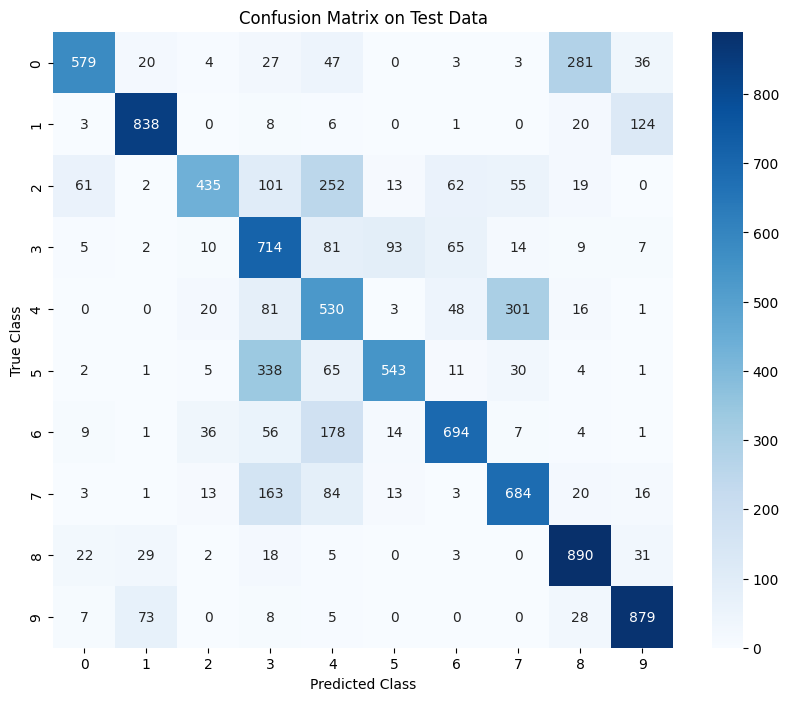


Class Labels:
airplane
automobile
bird
cat
deer
dog
frog
horse
ship
truck


In [12]:
# Матриця плутанини
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 8))
conf_mat = confusion_matrix(test_labels, test_remapped)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix on Test Data')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

print("\nClass Labels:")
for label in cifar10_classes:
    print(label)

In [13]:
# Функція для показу прикладів кластерів
def show_cluster_examples(dataloader, cluster_assignments, n_clusters, n_samples=5):
    cluster_images = {i: [] for i in range(n_clusters)}
    cluster_labels = {i: [] for i in range(n_clusters)}
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )

    i = 0
    for images, labels in dataloader:
        for img, label, cluster in zip(images, labels, cluster_assignments[i:i+len(images)]):
            if len(cluster_images[cluster]) < n_samples:
                img = inv_normalize(img)
                img = img.clip(0, 1)
                cluster_images[cluster].append(img)
                cluster_labels[cluster].append(label.item())
        i += len(images)

        if all(len(cluster_images[j]) >= n_samples for j in range(n_clusters)):
            break

    plt.figure(figsize=(15, 12))
    for cluster in range(n_clusters):
        for idx, (img, label) in enumerate(zip(cluster_images[cluster], cluster_labels[cluster])):
            plt.subplot(n_clusters, n_samples, cluster * n_samples + idx + 1)
            plt.imshow(img.permute(1, 2, 0).cpu().numpy())
            plt.title(f"C{cluster}: {cifar10_classes[label]}")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

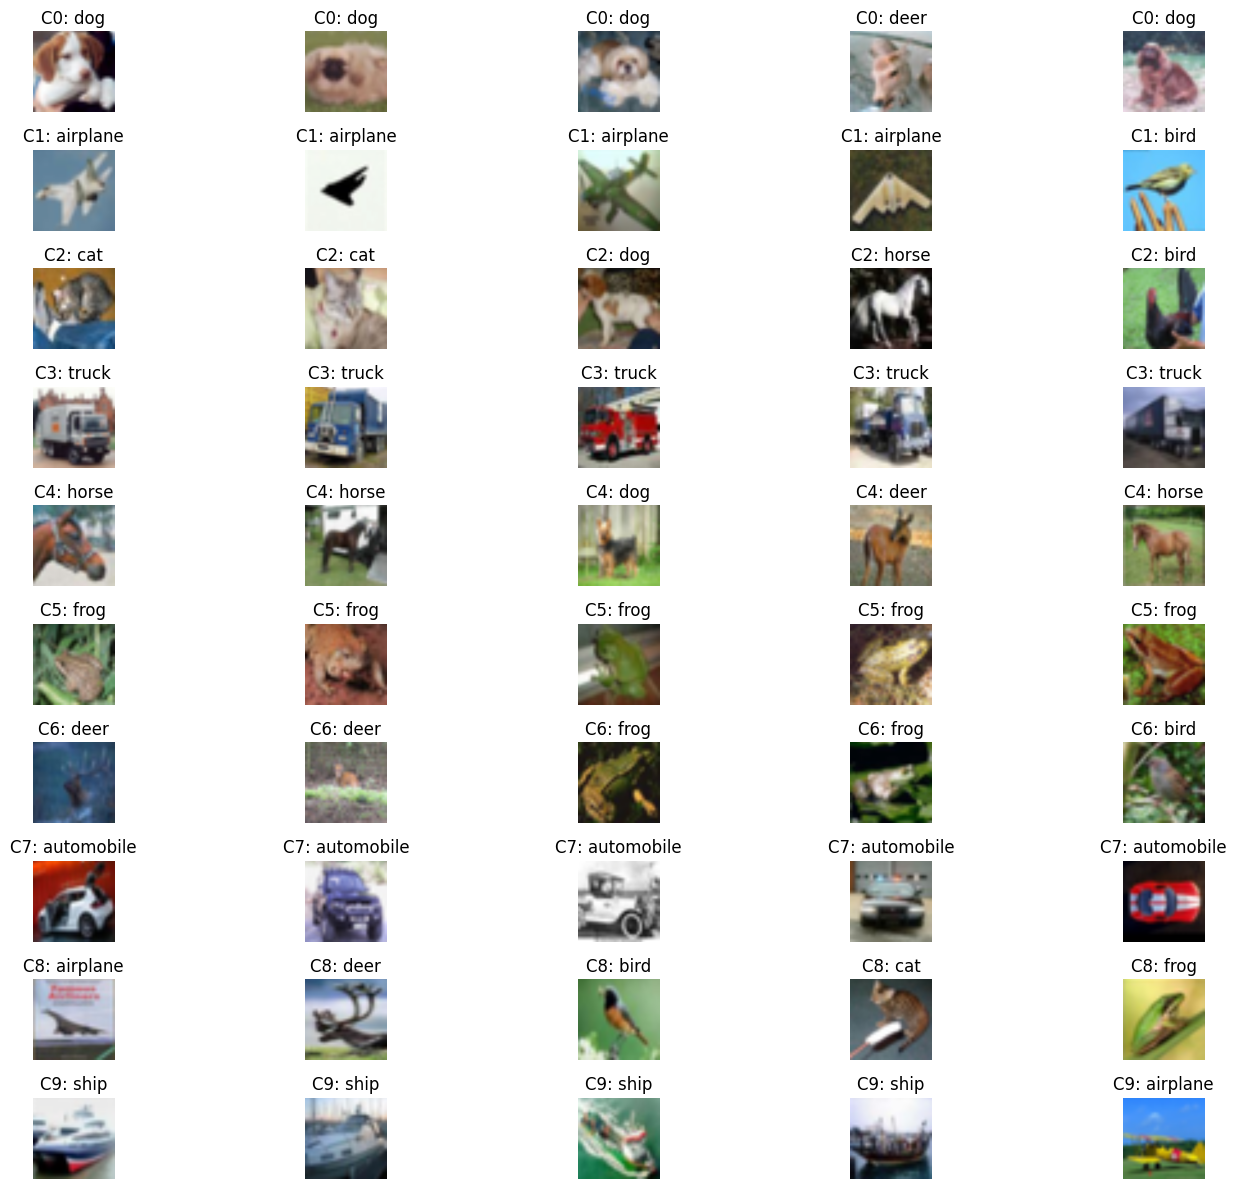

In [14]:
# Побудова підмножини для демонстрації кластерів
subset_size = 1000
subset_features = test_features[:subset_size]
subset_labels = test_labels[:subset_size]
subset_clusters = kmeans.predict(subset_features)

raw_subset_images = testset.data[:subset_size]

transform_for_display = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

processed_images = torch.stack([
    transform_for_display(ToPILImage()(img)) for img in raw_subset_images
])

subset_dataset = torch.utils.data.TensorDataset(processed_images, torch.tensor(subset_labels))
subset_loader = DataLoader(subset_dataset, batch_size=100, shuffle=False, num_workers=2)

# Відображаємо приклади
show_cluster_examples(subset_loader, subset_clusters, n_clusters, n_samples=5)

In [15]:
# Підсумковий результат
print("\nCIFAR10 Classification Results using ResNet18 Features and KMeans Clustering:")
print(f"Number of clusters: {n_clusters}")
print(f"Feature dimension: {train_features.shape[1]}")
print(f"Training accuracy: {train_accuracy:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Normalized Mutual Information: {test_nmi:.4f}")


CIFAR10 Classification Results using ResNet18 Features and KMeans Clustering:
Number of clusters: 10
Feature dimension: 512
Training accuracy: 0.6807
Test accuracy: 0.6786
Normalized Mutual Information: 0.5591
